In [1]:
#@title Install libraries for macOS to run tensorflow using available GPU (optional)
%pip install tensorflow-metal tensorflow-macos

Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Installations
%pip install pandas numpy matplotlib seaborn medmnist scikit-learn Pillow tensorflow opencv-python scikit-image tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
#@title Set GPU memory growth
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print('gpus',gpus)

gpus [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#@title Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from medmnist import RetinaMNIST
import PIL as pill
import pandas as pd
from collections import Counter
from abc import ABC, abstractmethod
from typing import Sequence
import seaborn as sns;
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import os
import datetime
from tensorflow.keras.metrics import AUC
from tensorflow import keras

In [5]:
#@title Dataset Download
train = RetinaMNIST(split='train',download=True,size=64)
test = RetinaMNIST(split='test',download=True,size=64)
val = RetinaMNIST(split='val',download=True,size=64)

*********        Dataset Description        *********
Dataset RetinaMNIST of size 64 (retinamnist_64)
    Number of datapoints: 1080
    Root location: /Users/saiharshagangari/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
*********        Plotting sample images        *********


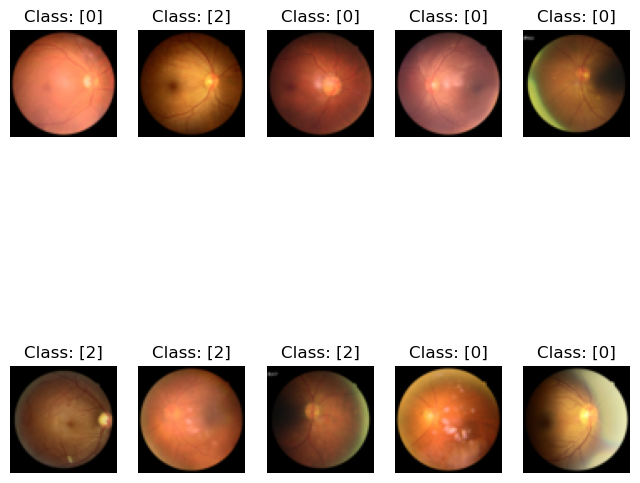

In [6]:
#@title Elementary Data Analysis
#Determine each category format: {class label, train sample count}
#RetinaMNIST = " {0:486, 1:128, 2:206, 3: 194, 4: 66}"
train_dataset = list(train)

def describe_dataset(train_data):
    print(train)

def plot_images(train_subset):
    try:
        figure, axes = plt.subplots(2,5, figsize=(8,8))
        axes = axes.flatten()
        for id in range(0,10):
            img,lbl = train_subset[id]
            axes[id].imshow(img)
            axes[id].set_title(f'Class: {lbl}')
            axes[id].axis('off')
        plt.show()


    except Exception as e:
        print('Error' ,e)

print('*********        Dataset Description        *********')
describe_dataset(train)

print('*********        Plotting sample images        *********')
sample_subset = list(train)[570:580]
plot_images(sample_subset)


*****          Visualize class 4 samples       ********


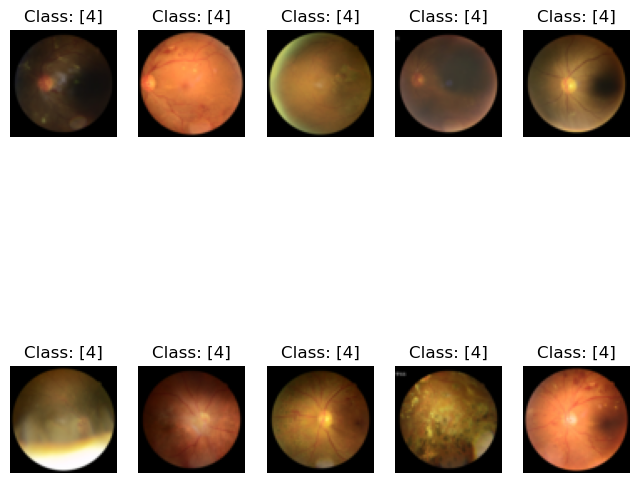

 ********         Shape of image         ********
shape of image: (64, 64) and label size:  1


66

In [7]:
# <h3>EDA Part 2</h3>
class4_dataset = [x for x in train_dataset if x[1] == 4]

print("*****          Visualize class 4 samples       ********")
plot_images(class4_dataset[1:11])

print(" ********         Shape of image         ********")
image = class4_dataset[0][0]
label = class4_dataset[0][1]
print(f"shape of image: {image.size} and label size:  {label.size}")
train[0]


len(class4_dataset)

In [8]:
#@title Base Algorithm
class BaseLearningAlogrithm(ABC):
    @abstractmethod
    def fit(self,xtrain:np.array,ytrain:np.array,xval:np.array,yval:np.array) -> tf.keras.callbacks.History:
        """Implement custom logic to train the GAN using train and validation data"""

    @abstractmethod
    def predict(self,xtest:list,ytest:list)->list:
        """Implement custom logic to test the GAN using test data"""

    @property
    @abstractmethod
    def name(self)->str:
        """Returns algorithm name"""

    @property
    def layers(self)-> Sequence[tf.keras.layers.Layer]:
        raise NotImplementedError()

    @property
    def input(self):
        raise NotImplementedError()


In [9]:
#@title Utility methods
def normalize_image(data):
    return data.astype('float32')/255.0

def prepare_x_y_columns(data:list):
    X = [np.array(sample[0]) for sample in data]
    Y = [np.array(sample[1]) for sample in data]
    X = normalize_image(np.array(X,dtype='float32'))
    Y = np.squeeze(to_categorical(np.array(Y,dtype='int'),num_classes=5))
    return (X,Y)

In [10]:
#@title Training and Evaluation methods
def train_eval(learning_algo: BaseLearningAlogrithm, ds_train, ds_val, ds_test):
  """Trains and evaluates the generic model."""

  history = learning_algo.fit(ds_train[0],ds_train[1], ds_val[0],ds_val[1])

  y_test = ds_test[1]
  images = ds_test[0]
  print('val input shape :',images.shape)
  y_pred =  learning_algo.predict(images)

  print("*******   Confusion Matrix *********")
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(5,5)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(5)],
              yticklabels=['%d' %i for i in range(5)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print("*******   Classification Report: *********")
  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(5)]))

  return history



RESNET model to extract features

In [ ]:
#@title Use RESNET to extract features
from tensorflow.keras.applications import ResNet50

class CNN(BaseLearningAlogrithm):
    def __init__(self):
        self.model = None
        self.epochs = 45
        self.loss = tf.losses.CategoricalCrossentropy()
        self.model = self.getmodel()
        self.learning_rate = 3e-4
        self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_rate=0.978, decay_steps=1000,staircase=False)
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
        self.history = None

    @property
    def layers(self):
        return self.model.layers
    
    def name(self)->str:
        return 'CNN hybrid model'
    
    def scheduler(self,epoch,currLearningRate):
        print('current epoch', epoch, 'current learning rate: ',currLearningRate)
        if epoch <= 15:
            return currLearningRate
        elif 16<= epoch <=20:
            return currLearningRate-currLearningRate*0.02
        elif 21<= epoch <= 25:
            return currLearningRate - currLearningRate*0.3
        elif 46<= epoch <=70:
            return currLearningRate - currLearningRate*0.45
        elif epoch>25:
            return currLearningRate * ((1-(epoch/self.epochs))**2)


    def getmodel(self) -> tf.keras.models.Sequential:
        hybrid_model = tf.keras.Sequential([
            ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3)),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(225,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(150,activation='relu'),
            # tf.keras.layers.Dropout(0.33),
            tf.keras.layers.Dense(80,activation='relu'),
            tf.keras.layers.Dense(30,activation='relu'),
            tf.keras.layers.Dropout(0.25),
            # tf.keras.layers.Dense(10,activation='relu'),
            tf.keras.layers.Dropout(0.1),

            #***********      Output layer       **********
            tf.keras.layers.Dense(5,activation='softmax')
        ])
        return hybrid_model
    


    def fit(self,xtrain,ytrain,xval,yval)->Sequence[tf.keras.callbacks.History]:
        print('Running fit method of CNN')
        callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=[metrics.Precision(name='precision'),
                                                                            metrics.Recall(name='recall'), 
                                                                            metrics.F1Score(name='f1_score'),
                                                                            metrics.AUC(name='auc',curve='ROC')
                                                                          ])
        self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[callback])
        return self.history

    def predict(self,xtest):
        return np.argmax(self.model.predict(xtest),axis=1)

In [ ]:
# #@title Create a CNN to establish benchmark
# from tensorflow.keras import metrics
# class CNN(BaseLearningAlogrithm):
#     def __init__(self):
#         self.epochs = 45
#         self.loss = tf.losses.CategoricalCrossentropy()
#         self.model = self.getmodel()
#         self.learning_rate = 3e-4

#         # self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_rate=0.978, decay_steps=1000,staircase=False)
#         self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
#         self.history = None



#     def scheduler(self,epoch,currLearningRate):
#         print('current epoch', epoch, 'current learning rate: ',currLearningRate)
#         if epoch <= 15:
#             return currLearningRate
#         elif 16<= epoch <=20:
#             return currLearningRate-currLearningRate*0.02
#         elif 21<= epoch <= 25:
#             return currLearningRate - currLearningRate*0.3
#         elif 46<= epoch <=70:
#             return currLearningRate - currLearningRate*0.45
#         elif epoch>25:
#             return currLearningRate * ((1-(epoch/self.epochs))**2)

#     def name(self)->str:
#         return 'Base CNN'
    
#     @property
#     def getmodel(self)->tf.keras.models.Sequential:
#         cnn_model = tf.keras.models.Sequential([
#             # # **********       Build the convolutional layers   *********
#             tf.keras.layers.Input(shape=(64,64,3)),
#             tf.keras.layers.Conv2D(filters=150,kernel_size=25,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
#             tf.keras.layers.Conv2D(filters=100,kernel_size=15,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
#             tf.keras.layers.Conv2D(filters=125,kernel_size=10,activation='relu',padding='same'),
#             tf.keras.layers.MaxPool2D(pool_size=2,strides=1),
#             tf.keras.layers.Conv2D(filters=97,kernel_size=2,activation='relu',padding='same'),
#             tf.keras.layers.AvgPool2D(pool_size=2,strides=2),

#             tf.keras.layers.Flatten(), # Flatten the layers

#             #***********     Start of Feed forward Neural Network       **********
#             tf.keras.layers.Dense(225,activation='relu'),
#             tf.keras.layers.Dropout(0.2),
#             tf.keras.layers.Dense(150,activation='relu'),
#             # tf.keras.layers.Dropout(0.33),
#             tf.keras.layers.Dense(80,activation='relu'),
#             tf.keras.layers.Dense(30,activation='relu'),
#             tf.keras.layers.Dropout(0.25),
#             # tf.keras.layers.Dense(10,activation='relu'),
#             tf.keras.layers.Dropout(0.1),

#             #***********      Output layer       **********
#             tf.keras.layers.Dense(5,activation='softmax')

#         ])
#         return cnn_model

#     def fit(self,xtrain,ytrain,xval,yval)->Sequence[tf.keras.callbacks.History]:
#         print('Running fit method of CNN')
#         callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
#         self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=[metrics.Precision(name='precision'),
#                                                                             metrics.Recall(name='recall'),
#                                                                             metrics.F1Score(name='f1_score'),
#                                                                             metrics.AUC(name='auc')])
#         self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[callback])
#         return self.history

#     def predict(self,xtest):
#         return np.argmax(self.model.predict(xtest),axis=1)


In [25]:
#@title Prepare train, val, test datasets with appropriate format
X_train, Y_train = prepare_x_y_columns(train_dataset)
print(X_train.shape,Y_train.shape)
print(Y_train[40])

val_dataset = list(val)
X_val,Y_val = prepare_x_y_columns(val_dataset)
print(X_val.shape)


test_dataset = list(test)
X_test,Y_test = prepare_x_y_columns(test_dataset)
print(X_test.shape)
Y_test = np.argmax(Y_test,axis=1)



(1080, 64, 64, 3) (1080, 5)
[0. 1. 0. 0. 0.]
(120, 64, 64, 3)
(400, 64, 64, 3)


Running fit method of CNN
current epoch 0 current learning rate:  0.0003000000142492354
Epoch 1/45


2025-04-25 18:14:53.745457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 719ms/step - accuracy: 0.3594 - auc_1: 0.6709 - f1_score: 0.1861 - loss: 1.4721 - precision: 0.6647 - recall: 0.1361 - val_accuracy: 0.4500 - val_auc_1: 0.7038 - val_f1_score: 0.1241 - val_loss: 1.6768 - val_precision: 0.4500 - val_recall: 0.4500 - learning_rate: 3.0000e-04
current epoch 1 current learning rate:  0.0003000000142492354
Epoch 2/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 533ms/step - accuracy: 0.5147 - auc_1: 0.8026 - f1_score: 0.3254 - loss: 1.2449 - precision: 0.8487 - recall: 0.2858 - val_accuracy: 0.4500 - val_auc_1: 0.7050 - val_f1_score: 0.1241 - val_loss: 1.9643 - val_precision: 0.4500 - val_recall: 0.4500 - learning_rate: 3.0000e-04
current epoch 2 current learning rate:  0.0003000000142492354
Epoch 3/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step - accuracy: 0.5071 - auc_1: 0.8136 - f1_score: 0.3266 - loss: 1.1673 - precision: 0.8268 - recall: 0.2946 - val_accuracy: 0.1000 - val_auc_1: 0.5254 - val_f1_score: 0.0364 - val_loss: 4.6991 - val_pre

2025-04-25 18:24:15.913471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
*******   Confusion Matrix *********
*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.67      0.79      0.72       174
           1       0.27      0.24      0.25        46
           2       0.39      0.36      0.37        92
           3       0.48      0.37      0.42        68
           4       0.35      0.30      0.32        20

    accuracy                           0.53       400
   macro avg       0.43      0.41      0.42       400
weighted avg       0.51      0.53      0.52       400

CPU times: user 7min 28s, sys: 4min 33s, total: 12min 1s
Wall time: 9min 30s


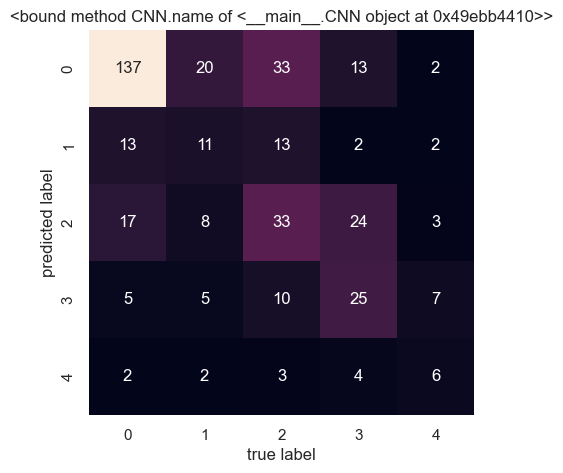

In [26]:
#@title Run the CNN model
cnn_model = CNN()
%time history = train_eval(cnn_model,(X_train,Y_train),(X_val,Y_val),(X_test,Y_test))


In [27]:
#@title Define function to plot loss curve Assuming
def plot_loss_curve(history,listOfMetrics):
    for metric in listOfMetrics:
        if metric not in history.history:
            print(f"Metric '{metric}' not found in history.")
            continue
        else:
            plt.plot(history.history[metric], label=f'{metric}')

    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

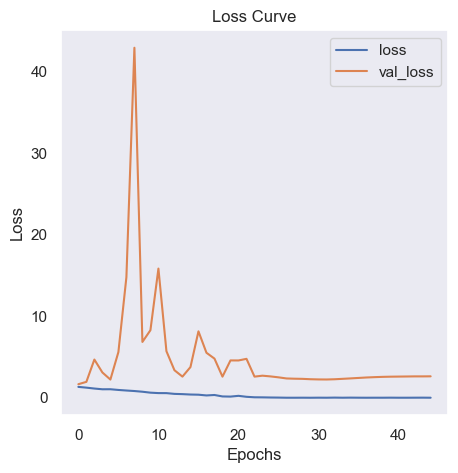

In [28]:
#@title Plot the loss curve
plot_loss_curve(history,['loss','val_loss'])


In [29]:
cnn_model.model.save('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/accuracy46_resnet_weights.keras')

TypeError: AUC.get_config() missing 1 required positional argument: 'self'

Start of GAN architecture

In [132]:
#@title Utility methods part 2
X_train=[]
Y_train=[]
def prepare_data_set(data):
  for sample in data:
    img = sample[0]
    label = sample[1][0]

    X_train.append(np.array(img,dtype='float32')/255.0)
    Y_train.append(label)


prepare_data_set(class4_dataset)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape,Y_train.shape)

(66, 64, 64, 3) (66,)


In [47]:
#@title Augment class 4 samples
def augment_class4_samples():
    class4_samples = []
    for img in X_train:
        # Rotate the image by 90 degrees
        rotated_img = np.rot90(img)
        class4_samples.append(rotated_img)

        # Flip the image horizontally
        flipped_img = np.fliplr(img)
        class4_samples.append(flipped_img)

        # Flip the image vertically
        flipped_img_vertical = np.flipud(img)
        class4_samples.append(flipped_img_vertical)

    return class4_samples


In [77]:
augmented_data = augment_class4_samples()
X_train = np.concatenate((X_train, np.array(augmented_data)), axis=0)
X_train.shape

(264, 64, 64, 3)

In [50]:
ds = tf.data.Dataset.from_tensor_slices((X_train))
ds = ds.batch(128)
ds = ds.shuffle(buffer_size=1080)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
ds.as_numpy_iterator().next()[0].shape

(64, 64, 3)

In [ ]:
#@title Architecting Generator
from tensorflow.keras.layers import (
    Conv2DTranspose, BatchNormalization, LeakyReLU, Input, Activation,Dense,Reshape,Conv2D
)
from tensorflow.keras.models import Model

def retinaGenerator(latent_dim=128):
    inputs = Input((latent_dim,))

    # project & reshape to a small “seed” feature map
    x = Dense(4*4*512, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4,4,512))(x)

    # upsample to 8×8
    x = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # upsample to 16×16
    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # upsample to 32×32
    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # upsample to 64×64
    x = Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # final RGB output
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    outputs = Activation('tanh')(x)

    return Model(inputs, outputs, name='retina_generator')


In [ ]:
generator = retinaGenerator()
generator.summary()

Model: "retina_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8192)           │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,436,131 (20.74 MB)

 Trainable params: 5,418,787 (20.67 MB)

 Non-trainable params: 17,344 (67.75 KB)

In [ ]:
#@title Model Architecture - Discriminator
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Activation

def retinaDiscriminator():
  model = tf.keras.Sequential()
  ( model.add(Conv2D(96,kernel_size=3,padding='same',input_shape=(64,64,3))))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))


  (model.add(Conv2D(54,kernel_size=4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  (model.add(Conv2D(48,4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))


  (model.add(Conv2D(18,4)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(500,activation='relu'))

  model.add(Dense(1))

  return model

In [ ]:
descriminator = retinaDiscriminator()
descriminator.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 54)     │        82,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 54)     │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 58, 58, 48)     │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 58, 58, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 58, 58, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 55, 55, 18)     │        13,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 55, 55, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 54450)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 500)            │    27,225,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,367,913 (104.40 MB)

 Trainable params: 27,367,481 (104.40 MB)

 Non-trainable params: 432 (1.69 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02237368..0.018803155].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[0.00044459]
 [0.00138176]
 [0.00137225]]


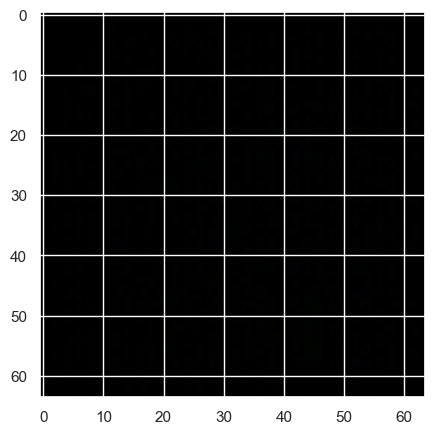

In [ ]:
#@title Print Sample image using generator
img = generator.predict(np.random.randn(3,128))
plt.imshow(np.array(img[2],dtype='float32'))

result = descriminator.predict(img)
print(result)


In [ ]:
#@title Defining Training loop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

gen_learningRate = 2.8e-4
disc_learningRate = 3e-5

gen_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(gen_learningRate,decay_steps=4800,end_learning_rate=9e-5,cycle=True)
disc_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(disc_learningRate,decay_steps=2000,end_learning_rate=8e-7,cycle=True)

# gen_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(gen_learningRate, decay_steps=1000, decay_rate=0.95)
# disc_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(disc_learningRate, decay_steps=1000, decay_rate=0.95)


genOptimizer = Adam(learning_rate=gen_learningRate,beta_1=0.0,beta_2=0.999)
discOptimizer = Adam(learning_rate=disc_learningRate,beta_1=0.0,beta_2=0.999)

lossFunction = BinaryCrossentropy(from_logits=False)




In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

class RetinaGAN(Model):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.generator = retinaGenerator()
        self.discriminator = retinaDiscriminator()
        self.latent_dim = latent_dim

    def compile(self, gen_optimizer, disc_optimizer, loss_fn):
        super().compile()  # no optimizers or losses here either
        #load generator and discriminator weights if already exists.
        try:
          print('loading weights')
          self.generator.load_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generator.weights.h5')
          self.discriminator.load_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/discriminator.weights.h5')
          print('weights loaded')
        except Exception as e:
          print('Error loading weights',e)


        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn

    def d_hinge_loss(self, real_logits, fake_logits):
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        return real_loss + fake_loss

    def g_hinge_loss(self,fake_logits):
      return -tf.reduce_mean(fake_logits)

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # 1) scale inputs if using tanh
        real_images = (real_images - 0.5) * 2.0

        # 2) sample noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        # 3) train discriminator with hinge loss

        for _ in range(4):

          with tf.GradientTape() as disc_tape:
              fake_images = self.generator(noise, training=True)
              real_logits = self.discriminator(real_images, training=True)
              fake_logits = self.discriminator(fake_images, training=True)

              d_loss = self.d_hinge_loss(real_logits, fake_logits)

          d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
          d_grads, _ = tf.clip_by_global_norm(d_grads, 1.0)
          self.disc_optimizer.apply_gradients(
              zip(d_grads, self.discriminator.trainable_weights)
          )

        # 4) train generator with hinge loss
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(noise, training=True)
            fake_logits = self.discriminator(fake_images, training=True)

            g_loss = self.g_hinge_loss(fake_logits)

        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}

In [52]:
#@title Create directory to store generated images
currentDate = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
image_dir_path = f'/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generated_images_gL_{gen_learningRate}_dL{disc_learningRate}_{currentDate}'
if not os.path.exists(image_dir_path):
    os.makedirs(image_dir_path)


NameError: name 'gen_learningRate' is not defined

In [ ]:
#@title Callback
from tensorflow.keras.callbacks import Callback
class RetinaGANMonitor(Callback):
  def __init__(self,num_img=20,latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img,self.latent_dim))
    generated_images = self.model.generator.predict(random_latent_vectors)
    generated_images = (generated_images*255).astype(np.uint8)
    # create directory to store images if not exists


    for i in range(self.num_img):
      img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
      img.save(f"{image_dir_path}/img-epoch-{epoch:03d}_{i}.png")

In [ ]:
#@title Run
retinaGAN = RetinaGAN()
retinaGAN.compile(genOptimizer,discOptimizer,lossFunction)

history = retinaGAN.fit(ds,epochs=300,callbacks=[RetinaGANMonitor()])

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


loading weights
weights loaded
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - d_loss: 0.1894 - g_loss: 14.5688
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.9584 - g_loss: 6.0425
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.6617 - g_loss: 5.0585
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.2873 - g_loss: 7.1031
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - d_loss: 1.0102 - g_loss: 5.6803
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.7000 - g_loss: 12.5972
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.5736 - g_loss: 12.2761
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - d_loss: 0.5226 - g_loss: 13.0

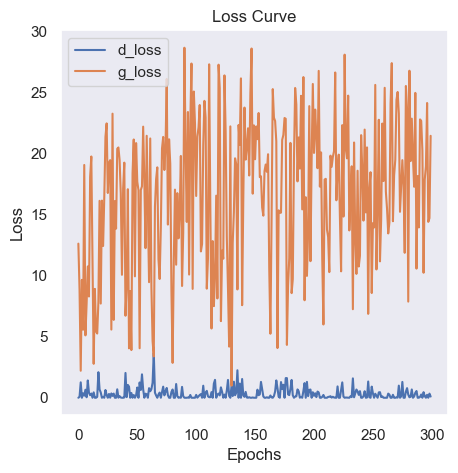

In [ ]:
metrics_list = ["d_loss", "g_loss"]

plot_loss_curve(history, metrics_list)



In [ ]:
#@title Save weights
retinaGAN.generator.save_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generator.weights.h5')
retinaGAN.discriminator.save_weights('/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/discriminator.weights.h5')

In [63]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# ——— 1) Paths ———
fake_dir = '/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/generated_images_gL_0.00028_dL3e-05_20250424-131935/'

# ——— 2) Load & preprocess all real images from class4_dataset ———
real_imgs = []
for img, _label in class4_dataset:
    arr = np.array(img)                   # PIL.Image → H×W×C or H×W
    if arr.ndim == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    arr = cv2.resize(arr, (64, 64))       # ensure 64×64
    arr = arr.astype(np.float32) / 255.0  # normalize to [0,1]
    real_imgs.append(arr)
real_imgs = np.stack(real_imgs, axis=0)   # shape = (N_real, 64, 64)

print('real image shape:', real_imgs[0].shape)

# ——— 3) Compute SSIM for each fake image ———
scores = []
for fn in os.listdir(fake_dir):
    fpath = os.path.join(fake_dir, fn)
    fake = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    fake = cv2.resize(fake, (64, 64))
    fake = fake.astype(np.float32) / 255.0

    # compare against all reals
    sims = [
        ssim(fake, real, data_range=1.0)
        for real in real_imgs
    ]
    scores.append((fn, max(sims)))

# ——— 4) Sort & pick top-50 ———
scores.sort(key=lambda x: x[1], reverse=True)
top50 = scores[:50]

print("Top 50 generated images by SSIM:")
for fn, score in top50:
    print(f"{fn}: SSIM={score:.4f}")



real image shape: (64, 64)
Top 50 generated images by SSIM:
img-epoch-071_10.png: SSIM=0.6445
img-epoch-184_15.png: SSIM=0.6188
img-epoch-126_17.png: SSIM=0.6147
img-epoch-167_14.png: SSIM=0.6085
img-epoch-204_0.png: SSIM=0.6066
img-epoch-072_19.png: SSIM=0.6063
img-epoch-179_7.png: SSIM=0.6058
img-epoch-077_15.png: SSIM=0.6033
img-epoch-124_14.png: SSIM=0.6004
img-epoch-266_17.png: SSIM=0.5966
img-epoch-075_0.png: SSIM=0.5958
img-epoch-109_5.png: SSIM=0.5953
img-epoch-266_0.png: SSIM=0.5934
img-epoch-106_8.png: SSIM=0.5898
img-epoch-228_11.png: SSIM=0.5889
img-epoch-076_4.png: SSIM=0.5858
img-epoch-167_11.png: SSIM=0.5850
img-epoch-111_16.png: SSIM=0.5846
img-epoch-074_18.png: SSIM=0.5840
img-epoch-223_13.png: SSIM=0.5823
img-epoch-204_6.png: SSIM=0.5813
img-epoch-281_18.png: SSIM=0.5811
img-epoch-026_5.png: SSIM=0.5799
img-epoch-294_18.png: SSIM=0.5781
img-epoch-217_17.png: SSIM=0.5780
img-epoch-207_16.png: SSIM=0.5773
img-epoch-288_2.png: SSIM=0.5772
img-epoch-188_6.png: SSIM=0.5771

In [ ]:
import shutil
print(base_dir)
save_dir = f"{base_dir}best_generatedimages/{currentDate}"
print(save_dir)
os.makedirs(save_dir, exist_ok=True)
for fn,_ in top50:
    shutil.copy(os.path.join(fake_dir, fn), save_dir)

/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/
/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/best_generatedimages/20250425-155642


# Retrain the CNN model using the synthetic images

In [134]:
#@title Prepare train dataset augmenting the synthetic dataset

from PIL import Image
fake_imgs_folder = f"{base_dir}best_generatedimages/synth_images/"
img_list =[]
print('dir',fake_imgs_folder)
for img in os.listdir(fake_imgs_folder):
  img_path = os.path.join(fake_imgs_folder,img)
  img = Image.open(img_path)
  img = img.convert('RGB')
  img = img.resize((64, 64))
  
  img_list.append((img,np.array([4])))


dir /Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/best_generatedimages/synth_images/


In [136]:
#@title Augment to X_train list

augment_x_train, augment_y_train = prepare_x_y_columns(img_list)

X_train = np.concatenate((X_train,augment_x_train),axis=0)
print(X_train.shape)
print(X_train[0].shape)



(1129, 64, 64, 3)
(64, 64, 3)


In [137]:
Y_train = np.concatenate((Y_train,augment_y_train),axis=0)
Y_train.shape


(1129, 5)

Running fit method of CNN
Epoch 1/45


2025-04-25 17:30:01.763513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3640 - auc_2: 0.6780 - f1_score: 0.2173 - loss: 1.5790 - precision: 0.5260 - recall: 0.1718

2025-04-25 17:31:19.670417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3661 - auc_2: 0.6797 - f1_score: 0.2185 - loss: 1.5737 - precision: 0.5309 - recall: 0.1733 - val_accuracy: 0.4500 - val_auc_2: 0.7327 - val_f1_score: 0.1241 - val_loss: 1.4444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/45
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 754ms/step - accuracy: 0.5144 - auc_2: 0.8118 - f1_score: 0.3781 - loss: 1.1784 - precision: 0.8179 - recall: 0.3118 - val_accuracy: 0.4500 - val_auc_2: 0.7336 - val_f1_score: 0.1241 - val_loss: 1.4615 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/45
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 652ms/step - accuracy: 0.4884 - auc_2: 0.8131 - f1_score: 0.3597 - loss: 1.1742 - precision: 0.8213 - recall: 0.2885 - val_accuracy: 0.4500 - val_auc_2: 0.6692 - val_f1_score: 0.1241 - val_loss: 1.5341 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/45
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - accuracy: 0.5499 - auc_2: 0.8506 - f1_score: 0.4549 - loss: 1.0803 -

2025-04-25 17:40:49.063697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step
*******   Confusion Matrix *********
*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       174
           1       0.26      0.13      0.17        46
           2       0.34      0.54      0.42        92
           3       0.32      0.18      0.23        68
           4       0.11      0.10      0.10        20

    accuracy                           0.50       400
   macro avg       0.35      0.34      0.33       400
weighted avg       0.49      0.50      0.48       400

CPU times: user 7min 59s, sys: 5min 19s, total: 13min 18s
Wall time: 10min 56s


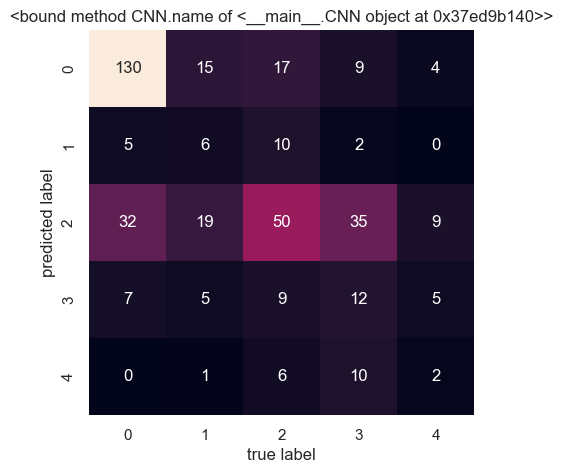

In [138]:
augment_cnn_model = CNN()
%time history = train_eval(augment_cnn_model,(X_train,Y_train),(X_val,Y_val),(X_test,Y_test))